In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import image
%matplotlib inline
import matplotlib.pylab as plt

from learning2learn.models import simple_cnn

np.random.seed(0)

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
X, labels = build_vocab_training_set(nb_exemplars, nb_categories, shape_fraction, color_fraction)

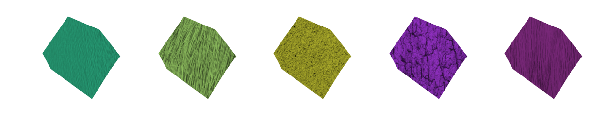

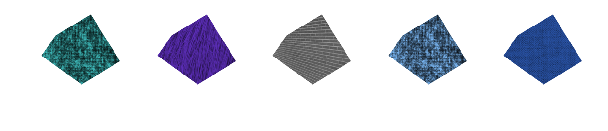

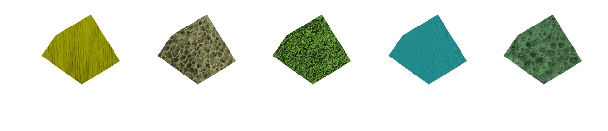

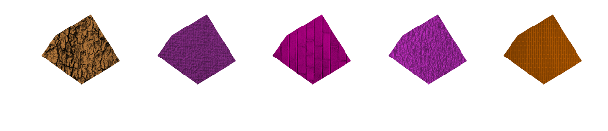

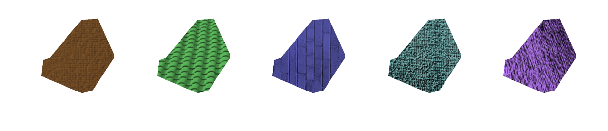

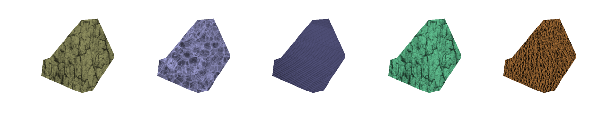

In [6]:
for i in range(6):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10,3))
    for j in range(5):
        #ix = i*5+j
        ix = 199 - (i*5+j)
        axes[j].imshow(X[ix])
        axes[j].axis('off')
    plt.show()

In [121]:
ohe = OneHotEncoder(sparse=False)
Y = ohe.fit_transform(labels.reshape(-1, 1))

In [122]:
model = simple_cnn(input_shape=X.shape[1:], nb_classes=Y.shape[-1])

In [124]:
# model.fit(
#     X, Y, epochs=50,
#     shuffle=True, 
#     verbose=1, batch_size=32
# )

## Now try figuring out custom logging...

In [152]:
def make_trial(shapes, colors, textures):
    # create a random trial
    ix = np.arange(len(shapes))
    while True:
        baseline = np.random.choice(ix)
        shape = shapes[baseline]
        color = colors[baseline]
        texture = textures[baseline]
        # only matches in shape
        shape_matches = \
        np.where((shapes == shape) &
                 (colors != color) &
                 (textures != texture))[0]
        # only matches in color
        color_matches = \
        np.where((shapes != shape) &
                 (colors == color) &
                 (textures != texture))[0]
        # only matches in texture
        texture_matches = \
        np.where((shapes != shape) &
                 (colors != color) &
                 (textures == texture))[0]

        if len(shape_matches) > 0 and len(color_matches) > 0 and len(
                texture_matches) > 0:
            break  # make sure we have an option for each image...

    shape_match = np.random.choice(shape_matches)
    color_match = np.random.choice(color_matches)
    texture_match = np.random.choice(texture_matches)

    return [baseline, shape_match, color_match, texture_match]

def build_test_trials(test_folder, nb_trials, target_size=(200, 200)):
    # First, load the images
    imgs = load_image_dataset(test_folder, target_size=target_size)
    # Collect the list of shapes, colors and textures
    feature_file = os.path.join(test_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)
    shapes = df['shape'].as_matrix()
    colors = df['color'].as_matrix()
    textures = df['texture'].as_matrix()

    # Sample the trials
    ix = []
    for i in range(nb_trials):
        ix.extend(make_trial(shapes, colors, textures))
    ix = np.asarray(ix)
    return imgs[ix]

In [153]:
from learning2learn.util import evaluate_secondOrder

In [142]:
from keras.callbacks import Callback, CSVLogger

class Logger(CSVLogger):
    def on_train_begin(self, logs={}):
        self.secondOrderAcc = []
        super(Logger, self).on_train_begin(logs)
 
    def on_epoch_end(self, epoch, logs={}):
        acc = evaluate_secondOrder(self.model, layer_num=-4)
        self.secondOrderAcc.append(acc)
        super(Logger, self).on_epoch_end(epoch, logs)

In [143]:
logger = Logger('../results/log.csv')
model.fit(
    X[:100], Y[:100], epochs=50,
    shuffle=True, 
    verbose=1, batch_size=32,
    callbacks=[logger]
)

Epoch 1/50
100/100 [==============================] - 59s 594ms/step - loss: 0.0189 - acc: 1.0000
Epoch 2/50
 96/100 [===========================>..] - ETA: 0s - loss: 0.0275 - acc: 1.0000

KeyboardInterrupt: 

## well, shit, that didn't work... let's try a different hack

In [155]:
test_folder = '../data/images_generated/test/'
X_test = build_test_trials(
    test_folder, nb_trials=100,
    target_size=(200, 200)
)

In [156]:
def save_scores(epoch, secondOrderAcc, vocabSize, logfile):
    df = pd.DataFrame(columns=['epoch', 'secondOrderAcc', 'vocabSize'])
    df['epoch'] = epoch
    df['secondOrderAcc'] = secondOrderAcc
    df['vocabSize'] = vocabSize
    df.to_csv(logfile, index=False)

In [208]:
def compute_vocab_size(model, X, Y, batch_size=64):
    # get predictions and ground truth
    y_true = Y.argmax(axis=1)
    y_pred = model.predict_classes(X, batch_size=batch_size)
    # collect accuracies for each class
    classes = np.unique(y_true)
    accuracies = np.zeros_like(classes, dtype=np.float32)
    for i, c in enumerate(classes):
        ix = np.where(y_true == c)[0]
        nb_correct = len(np.where(y_pred[ix] == c)[0])
        accuracies[i] = nb_correct / len(ix)
    # Compute vocab size.
    vocab_size50 = len(np.where(accuracies >= 0.15)[0])
    vocab_size80 = len(np.where(accuracies >= 0.8)[0])

    return vocab_size50, vocab_size80

In [215]:
compute_vocab_size(model, X, Y)

(1, 1)

In [175]:
def show_predictions(model, X, Y):
    y_true = Y.argmax(axis=1)
    y_pred = model.predict_classes(X, batch_size=64)
    classes = np.unique(y_true)
    for c in classes:
        ix = np.where(y_true == c)[0]
        print(y_true[ix])
        print(y_pred[ix])
        print('\n')

In [164]:
y_true = Y.argmax(axis=1)
y_pred = model.predict_classes(X, batch_size=64)

In [210]:
model = simple_cnn(input_shape=X.shape[1:], nb_classes=Y.shape[-1])

In [213]:
epoch = []
secondOrderAcc = []
vocabSize = []
for i in range(2):
    print('Epoch #%i' % (i+1))
    model.fit(
        X[:100], Y[:100], epochs=1,
        shuffle=True, 
        verbose=1, batch_size=32
    )
    acc = evaluate_secondOrder(
        model, X_test, layer_num=-4,
        batch_size=32
    )
    vs = compute_vocab_size(model, X, Y)
    epoch.append(i+1) # 1-indexed
    secondOrderAcc.append(acc)
    vocabSize.append(vs)
    #save_scores(epoch, secondOrderAcc, vocabSize, '../results/log.csv')

Epoch #1
Epoch 1/1
100/100 [==============================] - 3s 30ms/step - loss: 2.0999 - acc: 0.2700
Epoch #2
Epoch 1/1
100/100 [==============================] - 3s 30ms/step - loss: 1.7915 - acc: 0.3000


In [214]:
vocabSize

[(1, 1), (1, 1)]

## Now let's visualize the results of the experiment (which was done on compute node)

In [2]:
def plot_results(df, nb_categories=50, nb_epoch=100):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 20))

    # loss plot
    axes[0,0].plot(df.epoch, df.trainLoss)
    axes[0,0].set_xlabel('Epoch #', fontsize=14)
    axes[0,0].set_ylabel('Training loss', fontsize=14)
    axes[0,0].set_title('Training loss vs. epoch', fontsize=20)
    axes[0,0].set_xlim(0, nb_epoch)
    axes[0,0].set_xticks(list(range(0, nb_epoch,10)))
    # accuracy plot
    axes[0,1].plot(df.epoch, df.trainAcc)
    axes[0,1].set_xlabel('Epoch #', fontsize=14)
    axes[0,1].set_ylabel('Training accuracy', fontsize=14)
    axes[0,1].set_title('Training accuracy vs. epoch', fontsize=20)
    axes[0,1].set_ylim(0,1.1)
    axes[0,1].set_xlim(0, nb_epoch)
    axes[0,1].set_xticks(list(range(0, nb_epoch,10)))
    # vocab size 50% plot
    axes[1,0].plot(df.epoch, df.vocabSize50)
    axes[1,0].set_xlabel('Epoch #', fontsize=14)
    axes[1,0].set_ylabel('Vocab size', fontsize=14)
    axes[1,0].set_title('Vocab size (50%) vs. epoch', fontsize=20)
    axes[1,0].set_ylim(0, nb_categories+1)
    axes[1,0].set_xlim(0, nb_epoch)
    axes[1,0].set_xticks(list(range(0, nb_epoch,10)))
    # vocab size 80% plot
    axes[1,1].plot(df.epoch, df.vocabSize80)
    axes[1,1].set_xlabel('Epoch #', fontsize=14)
    axes[1,1].set_ylabel('Vocab size', fontsize=14)
    axes[1,1].set_title('Vocab size (80%) vs. epoch', fontsize=20)
    axes[1,1].set_ylim(0, nb_categories+1)
    axes[1,1].set_xlim(0, nb_epoch)
    axes[1,1].set_xticks(list(range(0, nb_epoch,10)))
    # shape bias plot
    axes[2,0].plot(df.epoch, df.secondOrderAcc)
    axes[2,0].set_xlabel('Epoch #', fontsize=14)
    axes[2,0].set_ylabel('Second-order gen. accuracy', fontsize=14)
    axes[2,0].set_title('Shape bias vs. epoch', fontsize=20)
    axes[2,0].set_ylim(0, 1.1)
    axes[2,0].set_xlim(0, nb_epoch)
    axes[2,0].set_xticks(list(range(0, nb_epoch,10)))

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

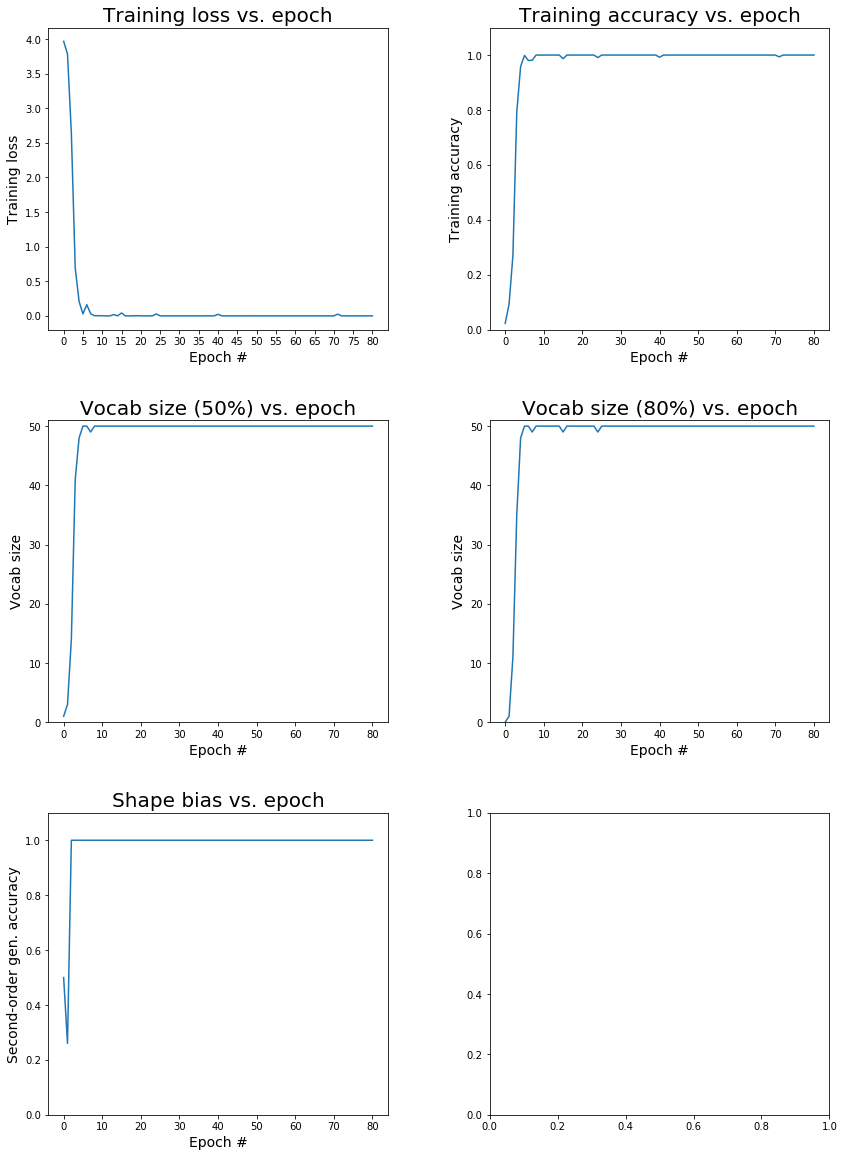

In [8]:
# cutout textures, no shift
df = pd.read_csv('../results/vocab_log.csv', index_col=False)
plot_results(df)

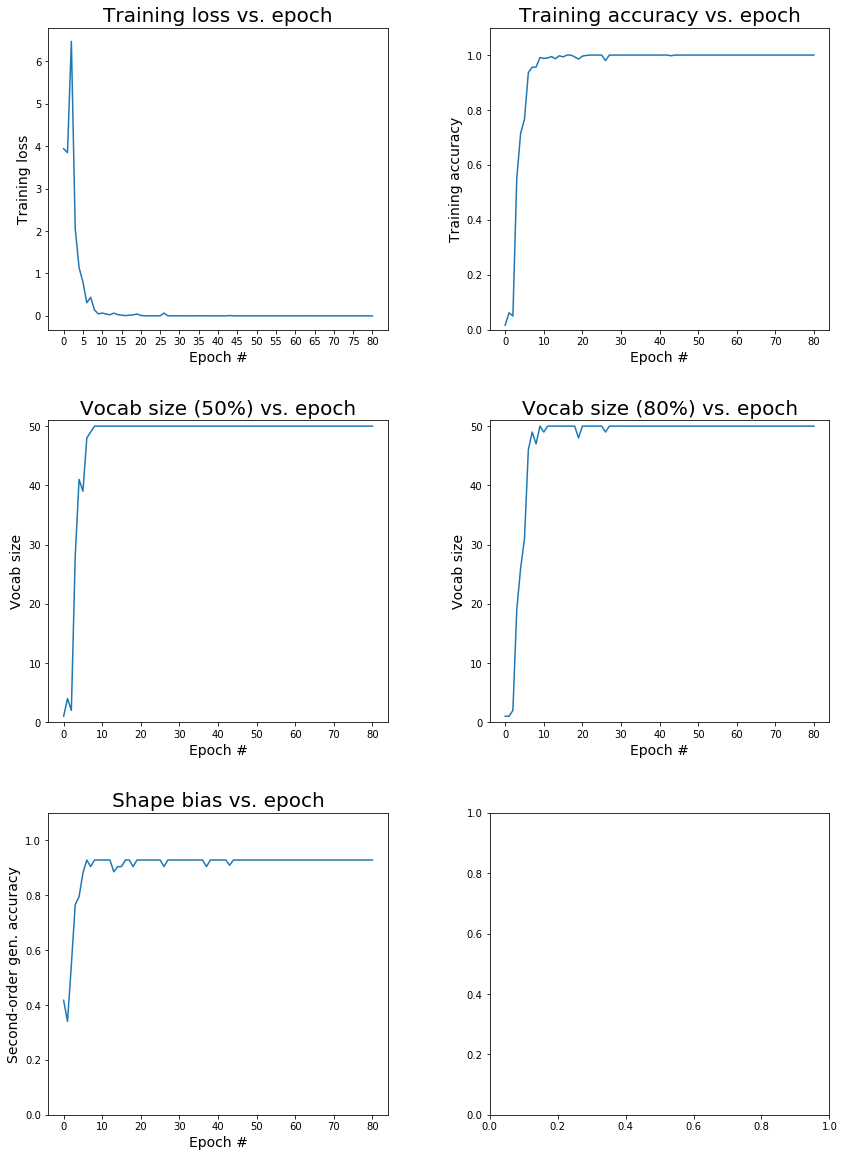

In [17]:
# cutout textures, shift=20
df = pd.read_csv('../results/vocab_log.csv', index_col=False)
plot_results(df)

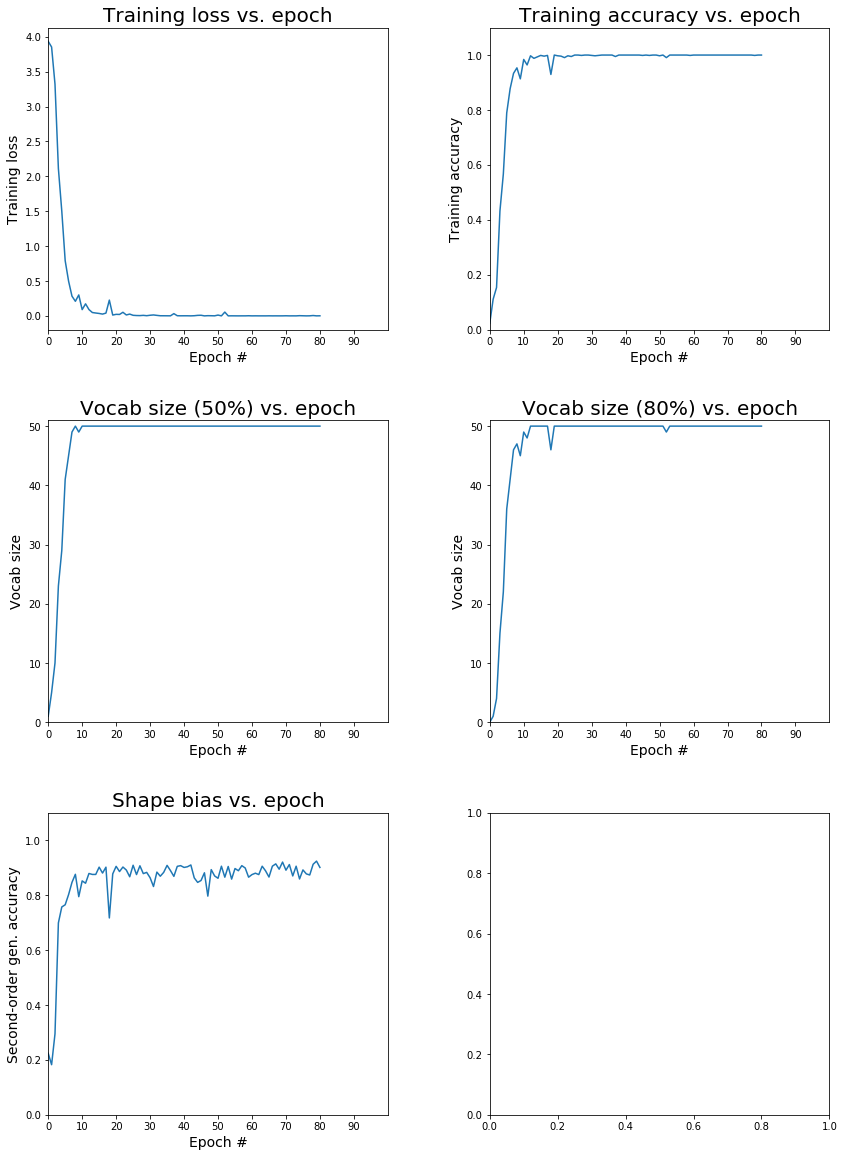

In [9]:
# cutout textures, no shift
df = pd.read_csv('../results/vocab_log.csv', index_col=False)
plot_results(df)

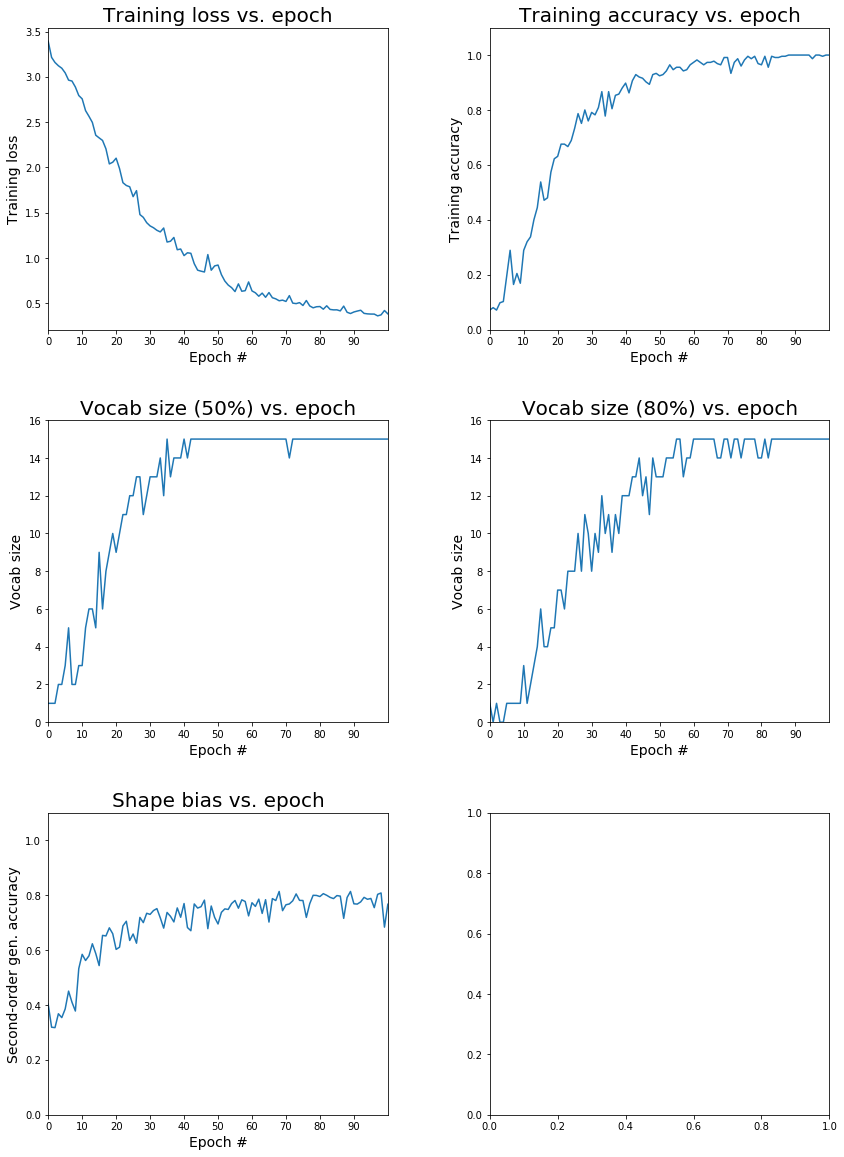

In [5]:
df = pd.read_csv('../results/vocab_log.csv', index_col=False)
plot_results(df, nb_categories=15)

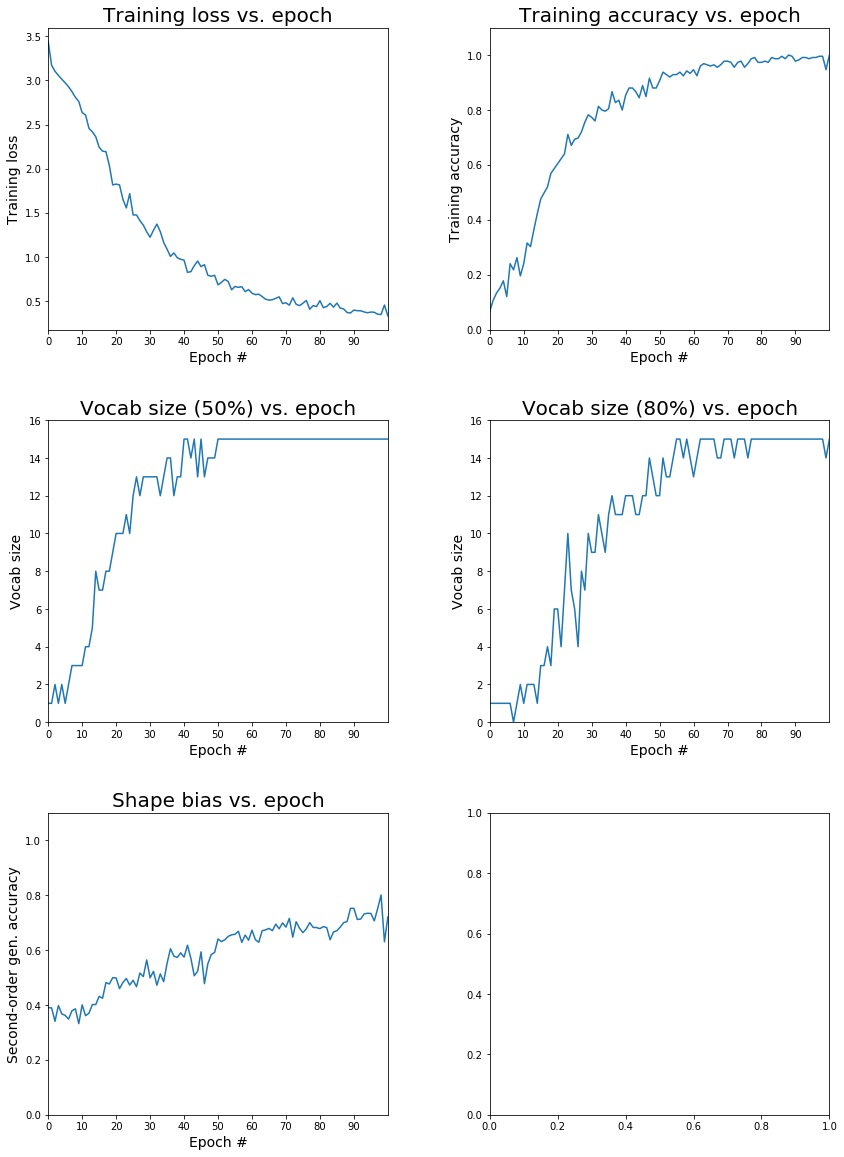

In [7]:
df = pd.read_csv('../results/vocab_log/run0.csv', index_col=False)
plot_results(df, nb_categories=15)

# More extensive analysis of shape and vocab acceleration

## First, we tried a model with 15 categories and 15 exemplars

In [34]:
def plot_multiple_runs(folder, nb_categories=50, nb_epoch=100):
    files = [file for file in os.listdir(folder) if file.endswith('csv')]
    dfs = [pd.read_csv(os.path.join(folder, file), index_col=False)
           for file in files]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    # vocab size 80% plot
    for df in dfs:
        axes[0].plot(df.epoch, df.vocabSize80)
    axes[0].set_xlabel('Epoch #', fontsize=16)
    axes[0].set_ylabel('Vocab size', fontsize=16)
    axes[0].set_title('Vocab size (80%) vs. epoch', fontsize=20)
    axes[0].set_ylim(0, nb_categories+1)
    axes[0].set_xlim(0, nb_epoch)
    axes[0].set_xticks(list(range(0, nb_epoch,10)))
    # shape bias plot
    for df in dfs:
        axes[1].plot(df.epoch, df.secondOrderAcc)
    axes[1].set_xlabel('Epoch #', fontsize=16)
    axes[1].set_ylabel('Second-order gen. accuracy', fontsize=16)
    axes[1].set_title('Shape bias vs. epoch', fontsize=20)
    axes[1].set_ylim(0, 1.1)
    axes[1].set_xlim(0, nb_epoch)
    axes[1].set_xticks(list(range(0, nb_epoch,10)))

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

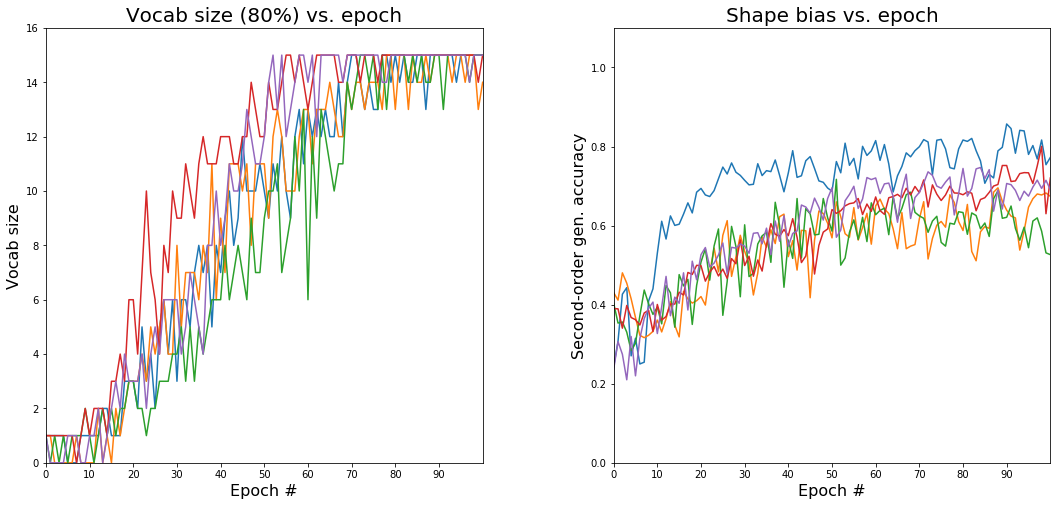

In [35]:
plot_multiple_runs('../results/vocab_log', nb_categories=15)

In [315]:
from sklearn.model_selection import train_test_split

def compute_error(x, y, d, nb_trials=10):
    errors = np.zeros(nb_trials)
    for i in range(nb_trials):
        x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.25)
        p = np.poly1d(np.polyfit(x_tr, y_tr, d))
        errors[i] = np.sum(np.square(y_te - p(x_te)))
    #print('score std: %0.4f' % np.std(errors))
    return np.mean(errors)

def assess_trial(df, d=None, plot=True):
    if d is not None:
        assert type(d) == int
        assert d >= 0
    # get epoch & vocab values
    epoch = df.epoch.values
    vs = df.vocabSize80.values
    sb = df.secondOrderAcc.values
    # compute best polynomial fit
    if d is None:
        poly_errors = [compute_error(epoch, vs, i, nb_trials=500) for i in range(10)]
        d = np.argmin(poly_errors)
        print('poly order: %i' % d)
    p = np.poly1d(np.polyfit(epoch, vs, d))
    if plot:
        # plot polynomial
        xp = np.linspace(0, 100, 100)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
        axes[0].plot(epoch, vs)
        axes[0].plot(xp, p(xp), '--')
        axes[0].set_title('vocabSize')
        axes[1].plot(epoch, sb)
        axes[1].set_ylim(0,1)
        axes[1].set_title('shapeBias')
        plt.show()
    # get derivative of polynomial
    p_d = np.polyder(p, 1)
    # build df with results
    results = pd.DataFrame(columns=['shapeBias', 'vocabVal', 'vocabDeriv'])
    results['shapeBias'] = df.secondOrderAcc.values
    results['vocabVal'] = [p(i) for i in epoch]
    results['vocabDeriv'] = [p_d(i) for i in epoch]
    
    return results

poly order: 5


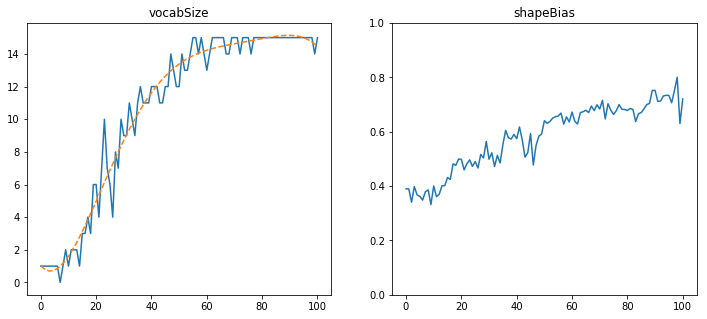

In [316]:
df = pd.read_csv('../results/vocab_log/run0.csv', index_col=False)
results = assess_trial(df)

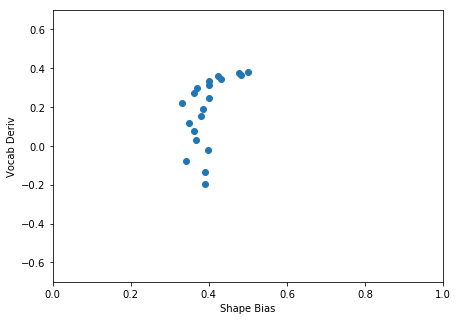

In [317]:
cutoff = 20
plt.figure(figsize=(7,5))
plt.scatter(results.shapeBias[:cutoff], results.vocabDeriv[:cutoff])
plt.xlabel('Shape Bias')
plt.ylabel('Vocab Deriv')
plt.xlim(0,1)
plt.ylim(-0.7, 0.7)
plt.show()

In [327]:
def assess_trial_set(folder, d=None, cutoff=20, plot=True, vs80=True):
    if d is not None:
        assert type(d) == int
        assert d >= 0
    files = sorted([file for file in os.listdir(folder) if file.endswith('csv')])
    dfs = [pd.read_csv(os.path.join(folder, file), index_col=False)
           for file in files]
    shapeBiases = []
    vocabDerivs = []
    for i, df in enumerate(dfs):
        # get epoch & vocab values
        epoch = df.epoch.values
        if vs80:
            vs = df.vocabSize80.values
        else:
            vs = df.vocabSize50.values
        sb = df.secondOrderAcc.values
        # compute best polynomial fit
        if d is None:
            poly_errors = [compute_error(epoch, vs, i, nb_trials=1000) for i in range(10)]
            d_p = np.argmin(poly_errors)
            print('polynomial order for %s: %i' % (files[i], d_p))
        else:
            d_p = d
        p = np.poly1d(np.polyfit(epoch, vs, d_p))
        # get derivative of polynomial
        p_d = np.polyder(p, 1)
        if plot:
            xp = np.linspace(0, 100, 100)
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
            axes[0].plot(epoch, vs)
            axes[0].plot(xp, p(xp), '--')
            axes[0].set_title('vocabSize')
            axes[1].plot(epoch, sb)
            axes[1].set_ylim(0, 1)
            axes[1].set_title('shapeBias')
            plt.show()
            print('\n')
        # consolidate results
        shapeBiases.extend(df.secondOrderAcc.values[:cutoff])
        vocabDerivs.extend([p_d(i) for i in range(cutoff)])
    
    return shapeBiases, vocabDerivs

In [354]:
def plot_correlation(shape_biases, vocab_derivs):
    corr, p = pearsonr(shape_biases, vocab_derivs)
    plt.figure(figsize=(7,5))
    plt.scatter(shape_biases, vocab_derivs, label='Pearson correlation: %0.4f' % corr)
    plt.xlabel('Shape Bias', fontsize=15)
    plt.ylabel('Vocab Deriv', fontsize=15)
    plt.xlim(0, 1)
    plt.legend(loc='lower right', fontsize=15)
    #plt.ylim(-1, 1)
    plt.show()

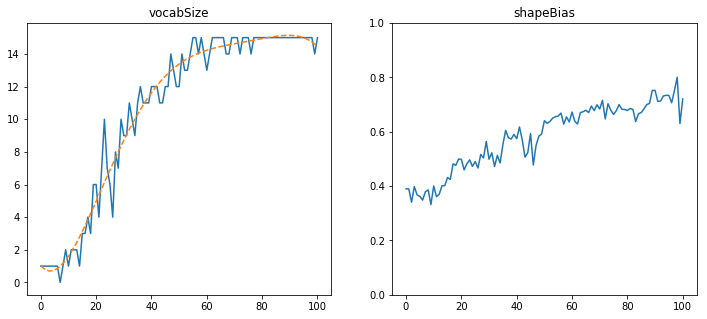

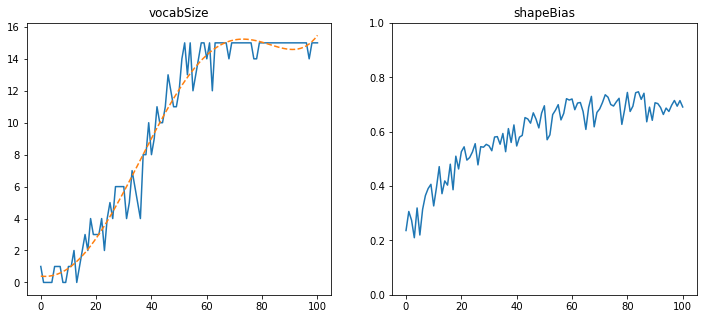

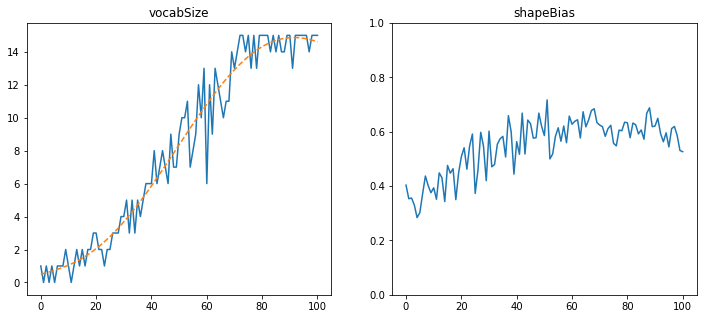

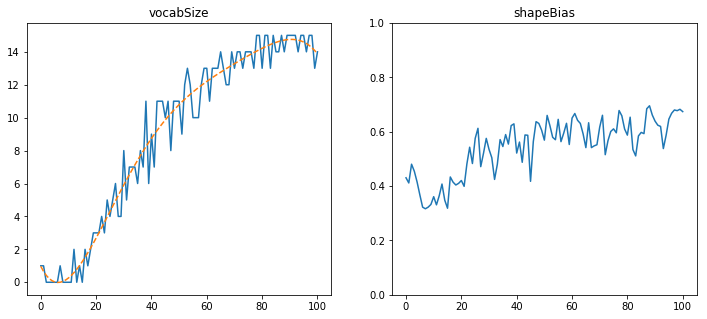

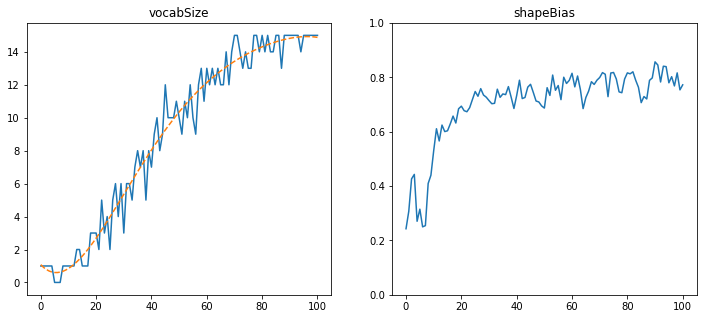

In [290]:
shape_biases, vocab_derivs = assess_trial_set('../results/vocab_log', d=5, cutoff=20)

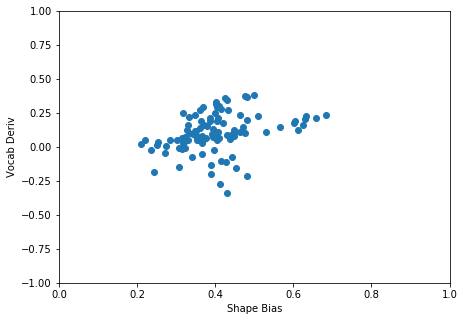

In [291]:
plot_correlation(shape_biases, vocab_derivs)

In [292]:
from scipy.stats.stats import pearsonr

corr, p = pearsonr(shape_biases, vocab_derivs)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

correlation: 0.3201
p-value: 0.0012


## Next we tried 30 categories and 15 exemplars

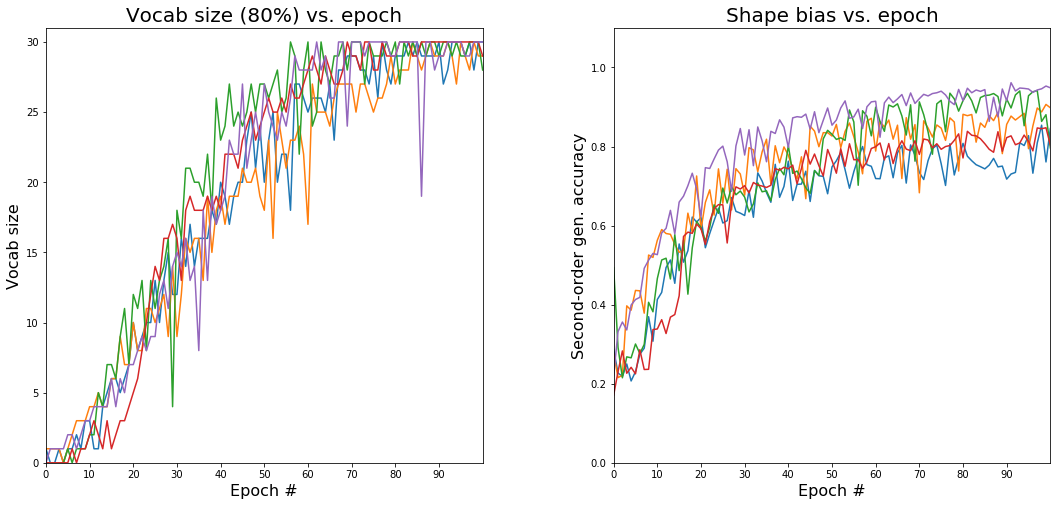

In [293]:
plot_multiple_runs('../results/vocab_log1', nb_categories=30)

poly order: 8


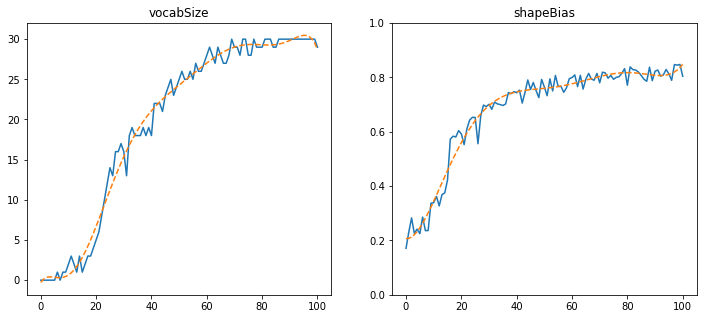

In [294]:
df = pd.read_csv('../results/vocab_log1/run0.csv', index_col=False)
results = assess_trial(df)

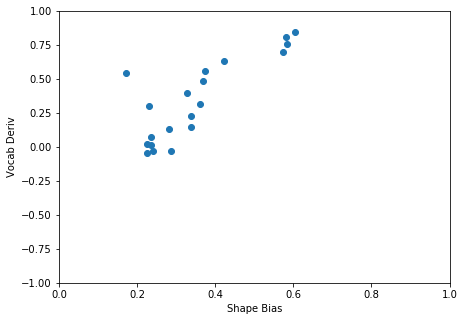

In [295]:
plot_correlation(results.shapeBias[:cutoff], results.vocabDeriv[:cutoff])

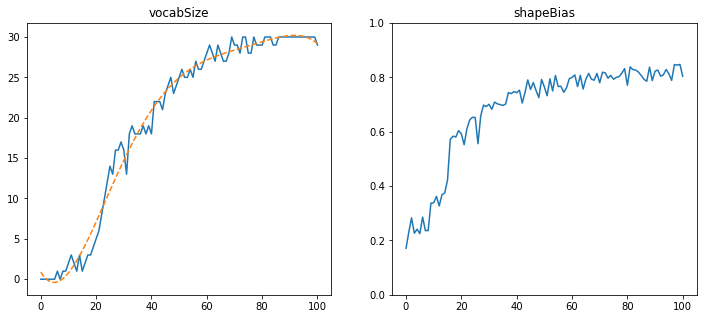

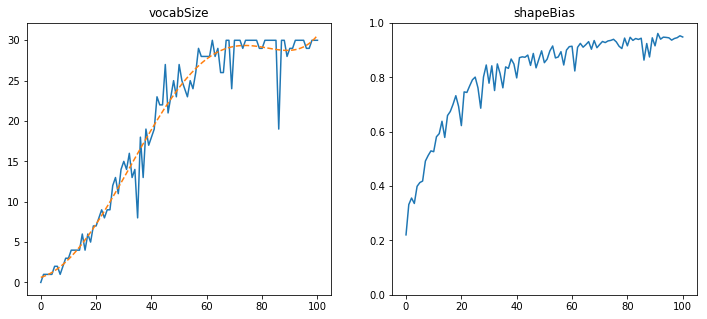

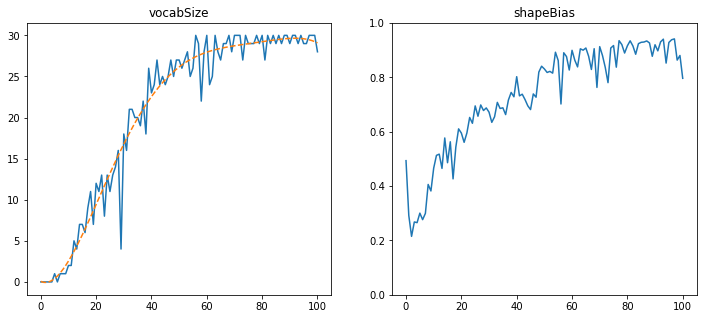

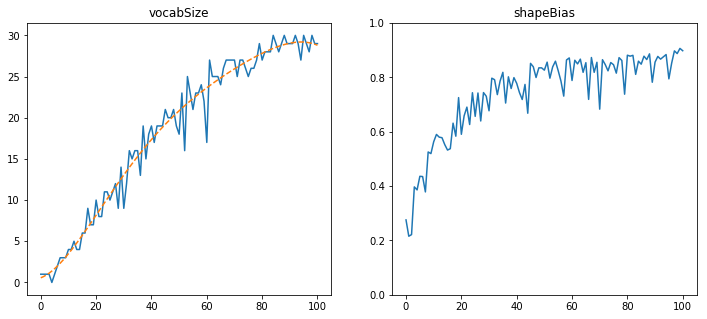

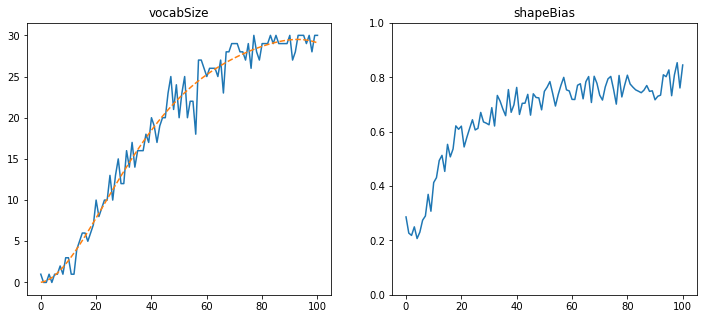

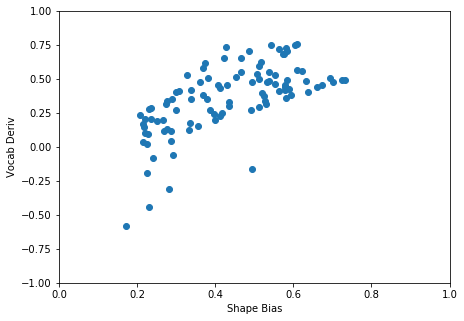

correlation: 0.65111
p-value: 0.00000


In [296]:
shape_biases, vocab_derivs = assess_trial_set('../results/vocab_log1', d=5, plot=True, cutoff=20)
plot_correlation(shape_biases, vocab_derivs)
corr, p = pearsonr(shape_biases, vocab_derivs)
print('correlation: %0.5f' % corr)
print('p-value: %0.5f' % p)

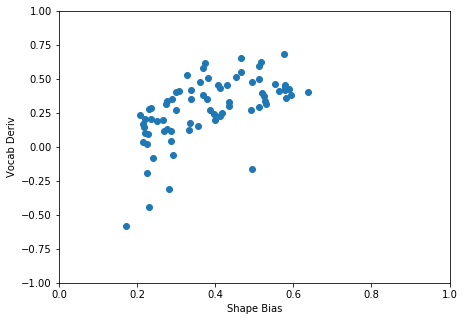

correlation: 0.5867
p-value: 0.0000


In [297]:
shape_biases, vocab_derivs = assess_trial_set('../results/vocab_log1', d=5, plot=False, cutoff=15)
plot_correlation(shape_biases, vocab_derivs)
corr, p = pearsonr(shape_biases, vocab_derivs)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

In [299]:
for i in range(10, 41):
    print('cutoff: %i' % i)
    shape_biases, vocab_derivs = assess_trial_set('../results/vocab_log1', d=5, plot=False, cutoff=i)
    corr, p = pearsonr(shape_biases, vocab_derivs)
    print('correlation: %0.4f' % corr)
    print('p-value: %0.4f' % p)

cutoff: 10
correlation: 0.4395
p-value: 0.0014
cutoff: 11
correlation: 0.4916
p-value: 0.0001
cutoff: 12
correlation: 0.5326
p-value: 0.0000
cutoff: 13
correlation: 0.5567
p-value: 0.0000
cutoff: 14
correlation: 0.5683
p-value: 0.0000
cutoff: 15
correlation: 0.5867
p-value: 0.0000
cutoff: 16
correlation: 0.5961
p-value: 0.0000
cutoff: 17
correlation: 0.6209
p-value: 0.0000
cutoff: 18
correlation: 0.6246
p-value: 0.0000
cutoff: 19
correlation: 0.6379
p-value: 0.0000
cutoff: 20
correlation: 0.6511
p-value: 0.0000
cutoff: 21
correlation: 0.6657
p-value: 0.0000
cutoff: 22
correlation: 0.6677
p-value: 0.0000
cutoff: 23
correlation: 0.6732
p-value: 0.0000
cutoff: 24
correlation: 0.6819
p-value: 0.0000
cutoff: 25
correlation: 0.6843
p-value: 0.0000
cutoff: 26
correlation: 0.6901
p-value: 0.0000
cutoff: 27
correlation: 0.6890
p-value: 0.0000
cutoff: 28
correlation: 0.6954
p-value: 0.0000
cutoff: 29
correlation: 0.6967
p-value: 0.0000
cutoff: 30
correlation: 0.6967
p-value: 0.0000
cutoff: 31
co

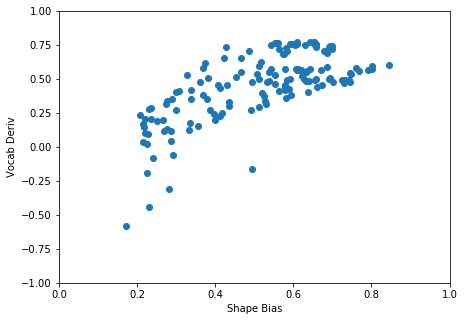

correlation: 0.6967
p-value: 0.0000


In [300]:
shape_biases, vocab_derivs = assess_trial_set('../results/vocab_log1', d=5, plot=False, cutoff=30)
plot_correlation(shape_biases, vocab_derivs)
corr, p = pearsonr(shape_biases, vocab_derivs)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

# Next we tried 50 categories and 20 exemplars

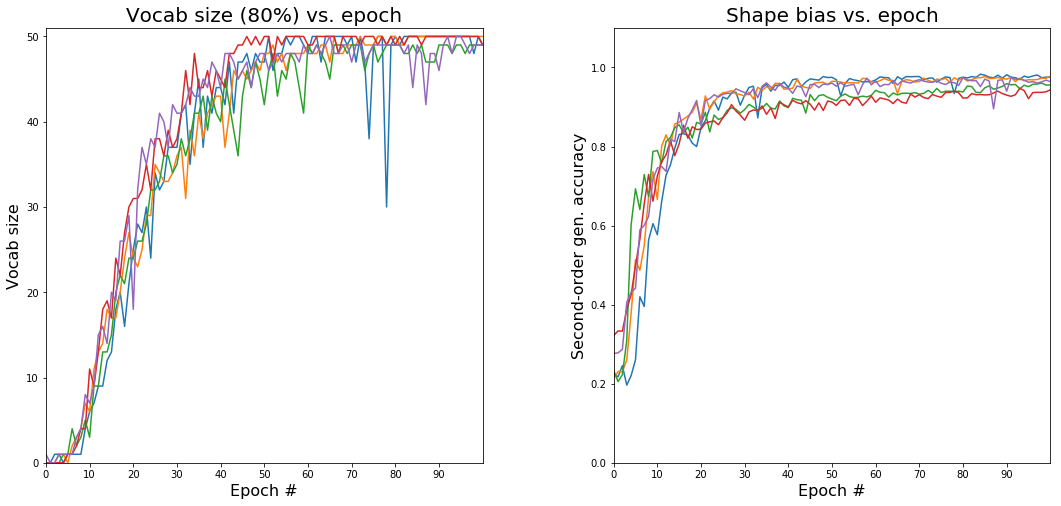

In [356]:
plot_multiple_runs('../results/vocab_log2', nb_categories=50)

polynomial order for run0.csv: 8


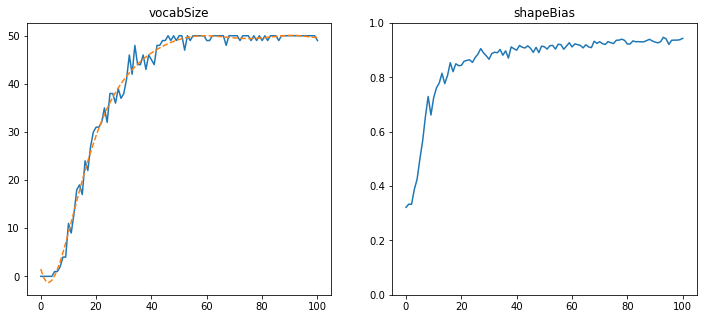



polynomial order for run1.csv: 9


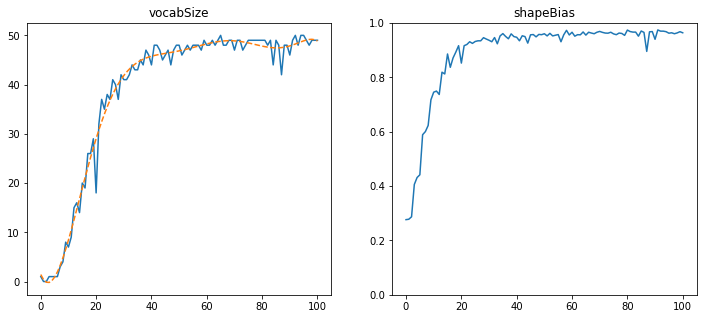



polynomial order for run2.csv: 7


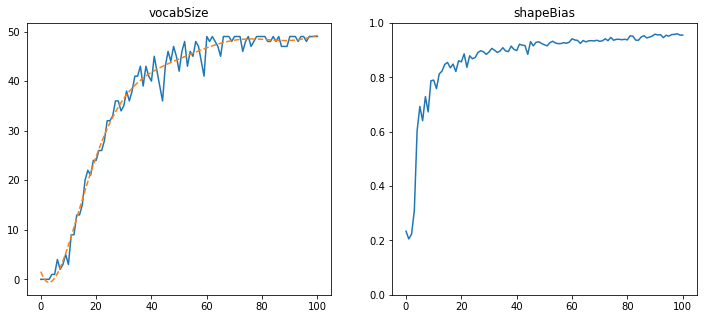



polynomial order for run3.csv: 8


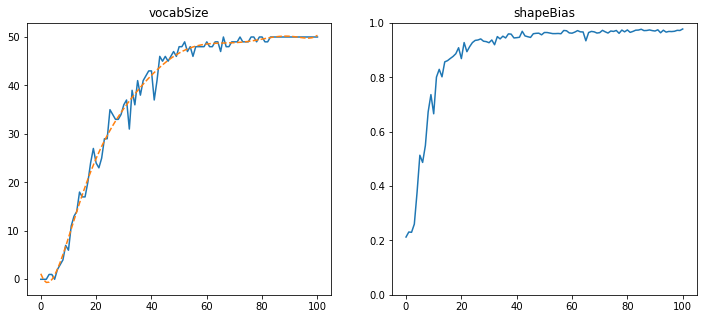



polynomial order for run4.csv: 9


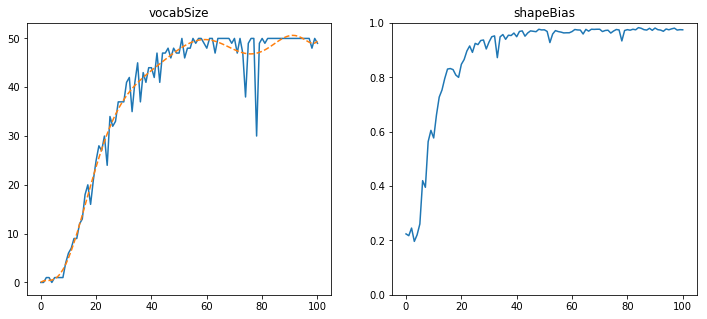

In [347]:
shape_biases, vocab_derivs = assess_trial_set('../results/vocab_log2', plot=True, cutoff=20)

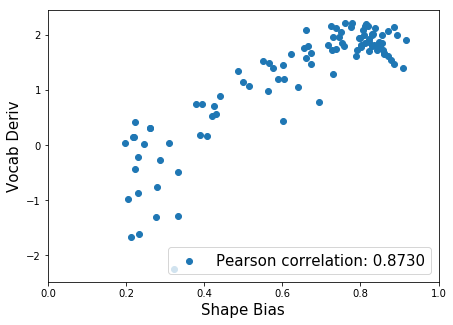

In [355]:
plot_correlation(shape_biases, vocab_derivs)

In [349]:
corr, p = pearsonr(shape_biases, vocab_derivs)
print('correlation: %0.4f' % corr)
print('p-value: %0.4f' % p)

correlation: 0.8730
p-value: 0.0000


In [338]:
for i in range(15, 25):
    print('cutoff: %i' % i)
    shape_biases, vocab_derivs = assess_trial_set('../results/vocab_log2', d=7, plot=False, cutoff=i)
    corr, p = pearsonr(shape_biases, vocab_derivs)
    print('correlation: %0.4f' % corr)
    print('p-value: %0.4f' % p)

cutoff: 15
correlation: 0.8862
p-value: 0.0000
cutoff: 16
correlation: 0.8867
p-value: 0.0000
cutoff: 17
correlation: 0.8867
p-value: 0.0000
cutoff: 18
correlation: 0.8850
p-value: 0.0000
cutoff: 19
correlation: 0.8818
p-value: 0.0000
cutoff: 20
correlation: 0.8753
p-value: 0.0000
cutoff: 21
correlation: 0.8707
p-value: 0.0000
cutoff: 22
correlation: 0.8597
p-value: 0.0000
cutoff: 23
correlation: 0.8501
p-value: 0.0000
cutoff: 24
correlation: 0.8366
p-value: 0.0000


poly order: 8


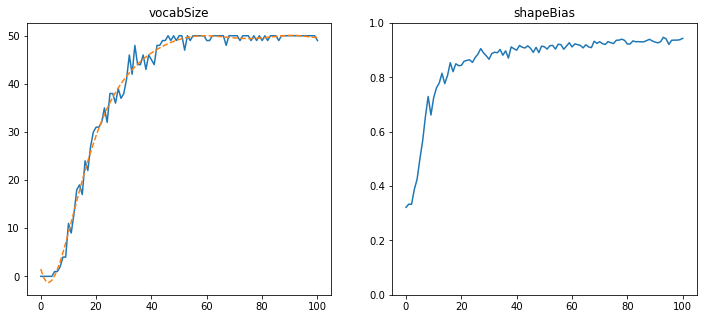

In [341]:
df = pd.read_csv('../results/vocab_log2/run0.csv', index_col=False)
results = assess_trial(df)

In [ ]:
def train_test_split(x, test_size):
    assert type(test_size) == int, 'test_size parameter must be an int'
    if test_size <= (len(x)/2.):
        nb_sample = test_size
    else:
        nb_sample = len(x) - test_size
    # evenly space selections accross the range of the input list
    step = int(np.floor(len(x) / nb_sample))
    ix = list(range(len(x)))
    ix1 = [i * step for i in range(nb_sample)]
    # center the selections
    diff = len(x) - 1 - max(ix1)
    shift = int(np.floor(diff/2.))
    ix1 = [i+shift for i in ix1]
    # the test set is the converse of the train set
    ix2 = list(set(ix).difference(ix1))
    if test_size <= (len(x)/2.):
        x_train = [x[i] for i in ix2]
        x_test = [x[i] for i in ix1]
    else:
        x_train = [x[i] for i in ix1]
        x_test = [x[i] for i in ix2]

    return x_train, x_test

In [443]:
import itertools

def get_intervals(nb_epoch, nb_sessions):
    assert nb_epoch % nb_sessions == 0
    step = int(nb_epoch/nb_sessions)
    return [i*step for i in range(nb_sessions)]

def plot_multiple_runs1(folder, nb_epoch=20, nb_sessions=10, save_file=None):
    intervals = get_intervals(nb_epoch, nb_sessions)
    files = [file for file in os.listdir(folder) if file.endswith('csv')]
    dfs = [pd.read_csv(os.path.join(folder, file), index_col=False)
           for file in files]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # vocab size 80% plot
    for df, marker in zip(dfs, itertools.cycle('o^+*s')):
        axes[0].plot(intervals, df.vocabSize80.iloc[intervals], marker=marker, markersize=10)
    axes[0].set_xlabel('Session', fontsize=16)
    axes[0].set_ylabel('Vocab size', fontsize=16)
    axes[0].set_title('Vocab Size (80%) vs. Session', fontsize=20)
    axes[0].set_ylim(0)
    axes[0].set_xlim(0, nb_epoch)
    axes[0].set_xticks(intervals)
    axes[0].set_xticklabels(range(nb_sessions))
    # shape bias plot
    for df, marker in zip(dfs, itertools.cycle('o^+*s')):
        acc = df.secondOrderAcc.iloc[intervals]
        #acc = list(itertools.accumulate(df.secondOrderAcc.iloc[intervals]))
        axes[1].plot(intervals, acc, marker=marker, markersize=10)
    axes[1].set_xlabel('Session', fontsize=16)
    axes[1].set_ylabel('Second-order gen. accuracy', fontsize=16)
    axes[1].set_title('Shape Bias vs. Session', fontsize=20)
    axes[1].set_ylim(0)
    axes[1].set_xlim(0, nb_epoch)
    axes[1].set_xticks(intervals)
    axes[1].set_xticklabels(range(nb_sessions))

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    if save_file is not None:
        plt.savefig(
            save_file,
            format='pdf',
            bbox_inches='tight'
        )
    else:
        plt.show()

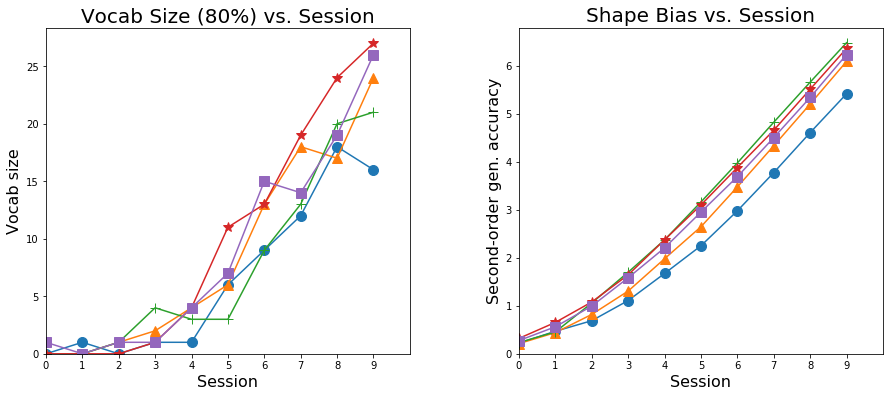

In [440]:
plot_multiple_runs1('../results/vocab_log2', nb_epoch=20, nb_sessions=10)

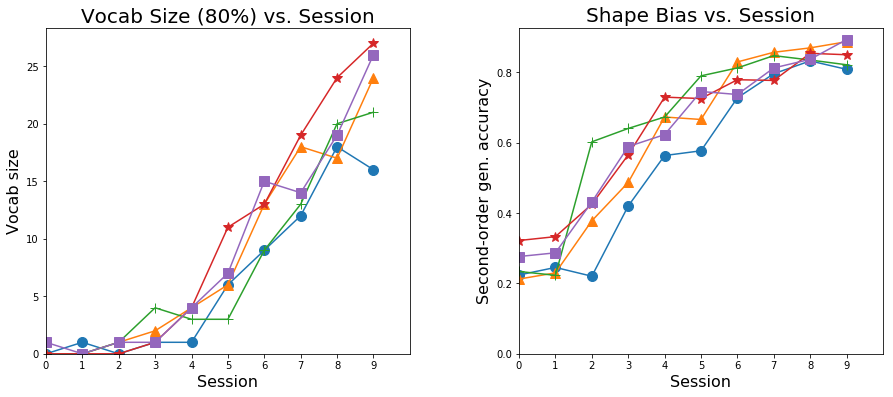

In [444]:
plot_multiple_runs1('../results/vocab_log2', nb_epoch=20, nb_sessions=10,
                    save_file='../paper_latex/figures/shapebias_and_vocab.pdf')

In [431]:
sb_am = 14/6
sb_jd = 19/7
sb_eb = 12/5
sb_tf = 24/5
sb_mm = 13/6
sb_zd = 23/7
sb_mp = 10/4
sb_eh = 25/8

In [430]:
dv_am = (48-9)/5
dv_jd = (108-20)/6
dv_eb = (61-22)/4
dv_tf = (123-45)/4
dv_mm = (49-9)/5
dv_zd = (78-14)/6
dv_mp = (62-20)/3
dv_eh = (61-15)/7

In [432]:
sb = [sb_am, sb_jd, sb_eb, sb_tf, sb_mm, sb_zd, sb_mp, sb_eh]
dv = [dv_am, dv_jd, dv_eb, dv_tf, dv_mm, dv_zd, dv_mp, dv_eh]

In [433]:
pearsonr(sb, dv)

(0.67741380060272827, 0.064928132068636707)